# Classification of Bank Marketing Success

## Importing Libraries

In [78]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
# Install Latex Fonts

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
dvipng is already the newest version (1.15-1).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [79]:
!pip install phik
!pip install scikit-learn -U
!pip install yellowbrick -U
!pip install imbalanced-learn -U
!pip install SciencePlots

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)
Requirement already up-to-date: yellowbrick in /usr/local/lib/python3.7/dist-packages (1.3.post1)
Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.7/dist-packages (0.8.0)


In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno
import phik
from tqdm import tqdm
plt.style.reload_library()
plt.style.use(['science', 'grid'])

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, plot_precision_recall_curve, plot_roc_curve, confusion_matrix
from yellowbrick.model_selection import learning_curve, feature_importances
from sklearn.inspection import permutation_importance

# Data Preprocessing
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTENC # Deal with Class Imbalance

# Models
from sklearn.dummy import DummyClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest

# Anomaly Detection
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Random State Instance. Using a RandomState instance sets the seed for the RNG generator. This allows for reproducible results, while still ensuring robust results (e.g. not overfitting to the random state)
random_state = np.random.RandomState(42) # also note that for cross validation, the splitter will be passed an integer while the actual estimator will be passed the random state instance, as recommended by scikit-learn documentation.

## Data Ingestion

In [81]:
bank_df = pd.read_csv("bank-full.csv", sep=";")
bank_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


## Data Exploration

In [82]:
bank_eda = bank_df.copy()

In [83]:
bank_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


At first glance, it seems there are no missing values and the data types are correct.

### Investigating The Target Variable

#### What is the prediction target?

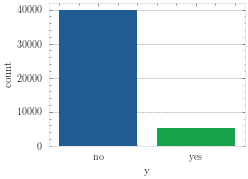

In [84]:
sns.countplot(data=bank_eda, x="y")
plt.savefig("class_dist.png", dpi=600)

We note that the classes are highly imbalanced, with most customers not signing up after marketing. This would suggest a strategy of oversampling may be required to handle imbalanced classes. It also suggests that we could treat the problem as an anomaly detection problem.

### Univariate Analysis

#### Quantitative Variables

In [85]:
numerical_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

##### Descriptive Statistics

In [86]:
bank_eda.describe().round(2).to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} &       age &    balance &       day &  duration &  campaign &     pdays &  previous \\\\\n\\midrule\ncount &  45211.00 &   45211.00 &  45211.00 &  45211.00 &  45211.00 &  45211.00 &  45211.00 \\\\\nmean  &     40.94 &    1362.27 &     15.81 &    258.16 &      2.76 &     40.20 &      0.58 \\\\\nstd   &     10.62 &    3044.77 &      8.32 &    257.53 &      3.10 &    100.13 &      2.30 \\\\\nmin   &     18.00 &   -8019.00 &      1.00 &      0.00 &      1.00 &     -1.00 &      0.00 \\\\\n25\\%   &     33.00 &      72.00 &      8.00 &    103.00 &      1.00 &     -1.00 &      0.00 \\\\\n50\\%   &     39.00 &     448.00 &     16.00 &    180.00 &      2.00 &     -1.00 &      0.00 \\\\\n75\\%   &     48.00 &    1428.00 &     21.00 &    319.00 &      3.00 &     -1.00 &      0.00 \\\\\nmax   &     95.00 &  102127.00 &     31.00 &   4918.00 &     63.00 &    871.00 &    275.00 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [87]:
bank_eda.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


- The middle 50% of all customers are of ages 33 to 48. The oldest customer is 95. This suggests most customers are middle aged, working adults.
- Some customers had a negative balance in their account, but the middle 50% had an average yearly balance of 72 to 1428 euros 
- With the exception of day, most quantitative features had mean values larger than the median, suggesting that their distributions are positively skewed.
- At least 75% of all clients had never been contacted by the bank for any campaigns. At least one client had not been contacted for more than two years.
- Almost all clients had never been contacted before by the bank as the 75% percentile for previous contacts is 0. However, the max of 275 suggests that a few were regular customers of the bank before.

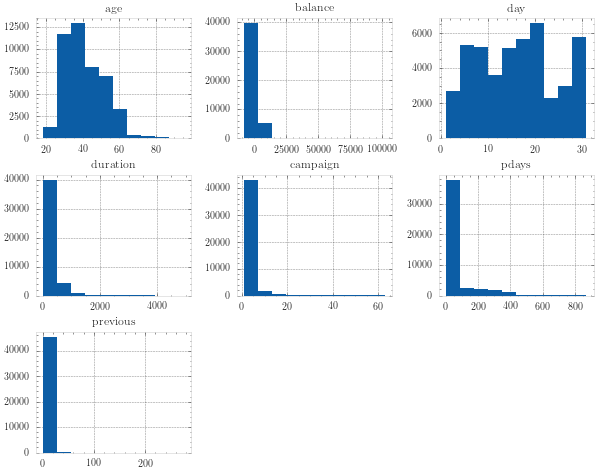

In [88]:
fig = bank_eda[numerical_features].hist(figsize=(10, 8))
plt.savefig("numerical_hist.png", dpi=600)

We note that with the exception of day, most of the quantitative data has a positively skewed distribution. 


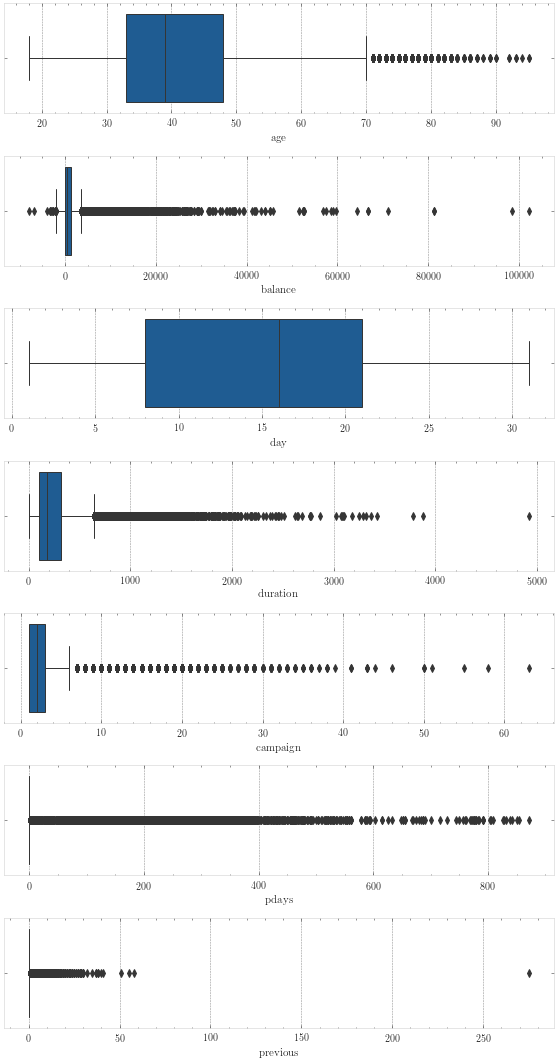

In [89]:
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(8, 15), tight_layout=True)
for idx, feature in enumerate(numerical_features):
    sns.boxplot(data=bank_eda, x=feature, ax = ax[idx])
fig.show()

- Balance has outliers with negative balance.
- All other columns have outliers that are above the upper quartile.

#### Qualitative Variables

In [90]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

In [91]:
bank_eda.describe(include='object').to_latex()

'\\begin{tabular}{lllllllllll}\n\\toprule\n{} &          job &  marital &  education & default & housing &   loan &   contact &  month & poutcome &      y \\\\\n\\midrule\ncount  &        45211 &    45211 &      45211 &   45211 &   45211 &  45211 &     45211 &  45211 &    45211 &  45211 \\\\\nunique &           12 &        3 &          4 &       2 &       2 &      2 &         3 &     12 &        4 &      2 \\\\\ntop    &  blue-collar &  married &  secondary &      no &     yes &     no &  cellular &    may &  unknown &     no \\\\\nfreq   &         9732 &    27214 &      23202 &   44396 &   25130 &  37967 &     29285 &  13766 &    36959 &  39922 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [92]:
bank_eda.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


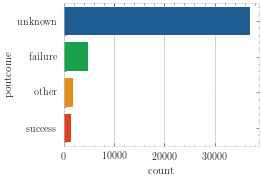

In [93]:
for idx, feature in enumerate(categorical_features):
  plt.clf()
  sns.countplot(data=bank_eda, y = feature)
  plt.savefig(f"{feature}.png", dpi=600)
fig.show()

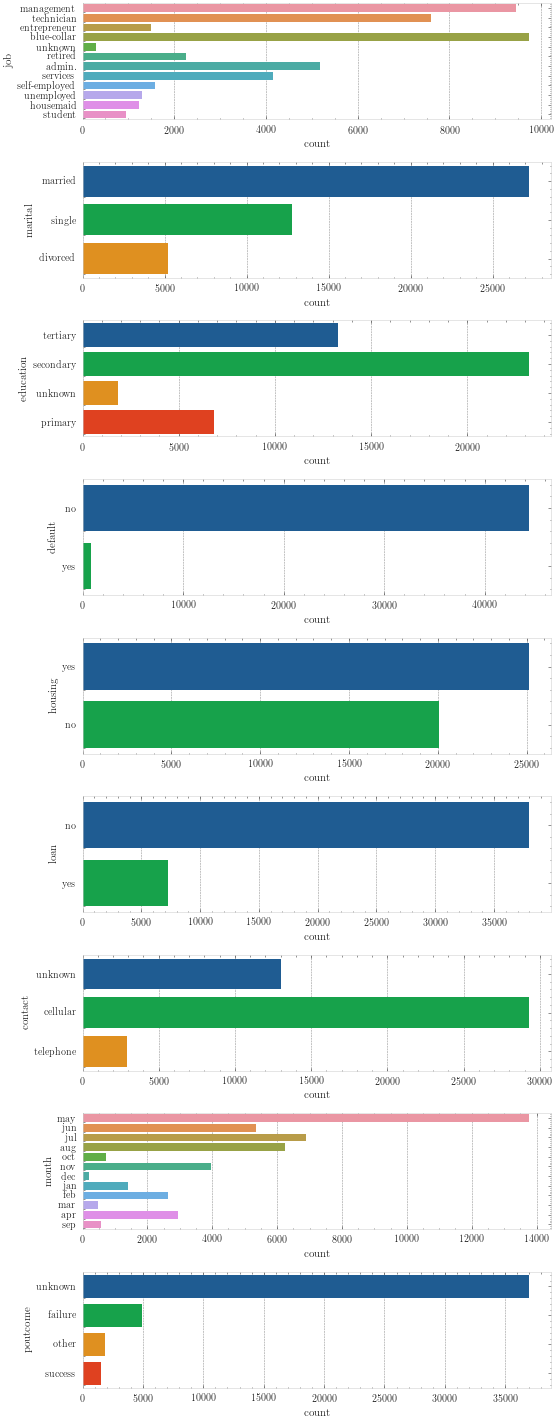

In [94]:
fig, ax = plt.subplots(len(categorical_features), 1, figsize=(8, 20), tight_layout = True)

for idx, feature in enumerate(categorical_features):
    sns.countplot(data=bank_eda, y = feature, ax = ax[idx])
fig.show()

### Investigating Missing Values
In the initial analysis, we found that no values in the data were marked as missing. However, during our EDA, we found that certain categorical variables had values marked as "unknown". 

This suggests that there are missing values in the data. However, to determine what to do with them, we first need to decide if these values are missing at random, or if they are missing for systematic reasons.

#### Types of Missing Data
| Type | Description |
|----|----|
|Missing At Random| Rubin (1978) defined MAR as occuring when "given variables X and Y, the probabilty of response depends on X but not Y"|

In [95]:
bank_eda_na = pd.read_csv("bank-full.csv", sep=";", na_values = {"poutcome": "unknown", "contact" : "unknown", "job" : "unknown", "education" : "unknown", "pdays" : -1})

In [96]:
bank_eda_na.isna().sum().sort_values(ascending=False)

poutcome     36959
pdays        36954
contact      13020
education     1857
job            288
housing          0
marital          0
default          0
balance          0
y                0
loan             0
day              0
month            0
duration         0
campaign         0
previous         0
age              0
dtype: int64

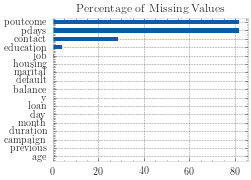

In [97]:
(bank_eda_na.isna().sum().sort_values(ascending=True) / len(bank_eda_na) * 100).plot(kind='barh', title="Percentage of Missing Values")

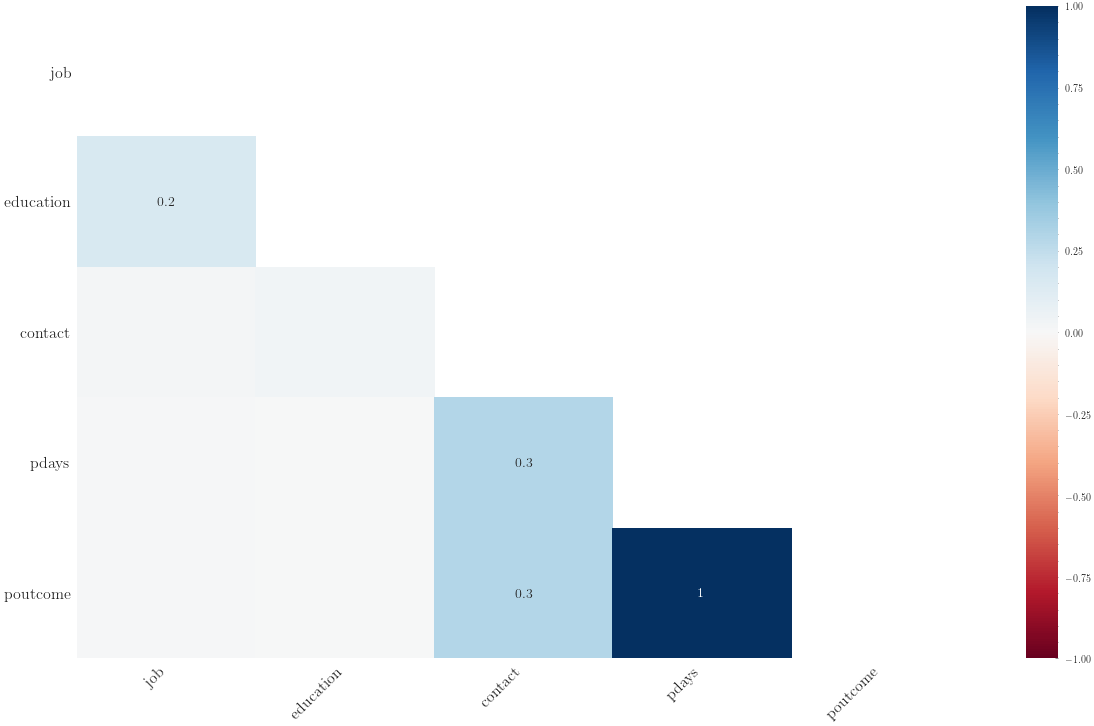

In [98]:
msno.heatmap(bank_eda_na)

It seems that those who had known jobs were more likely to have complete educational data. In addition, those who had a known outcome from a previous campaign were more likely to have a known form of contact. 

We note that there is a 1-1 correlation between a customer never being contacted before and knowing the outcome of the previous campaign. This suggests that missing past outcomes are MNAR (missing not at random). This is logical, as if they are new clients, we would never have contacted them before, and thus have no previous outcomes. Based off this information, it would be best if we kept unknown as an indicator value for `poutcome`.

### Bivariate Analysis

#### Pairplot

In [99]:
sns.pairplot(bank_eda, hue="y")

Error in callback <function flush_figures at 0x7f368ba5a440> (for post_execute):


KeyboardInterrupt: ignored

#### $\phi_k$ Correlation

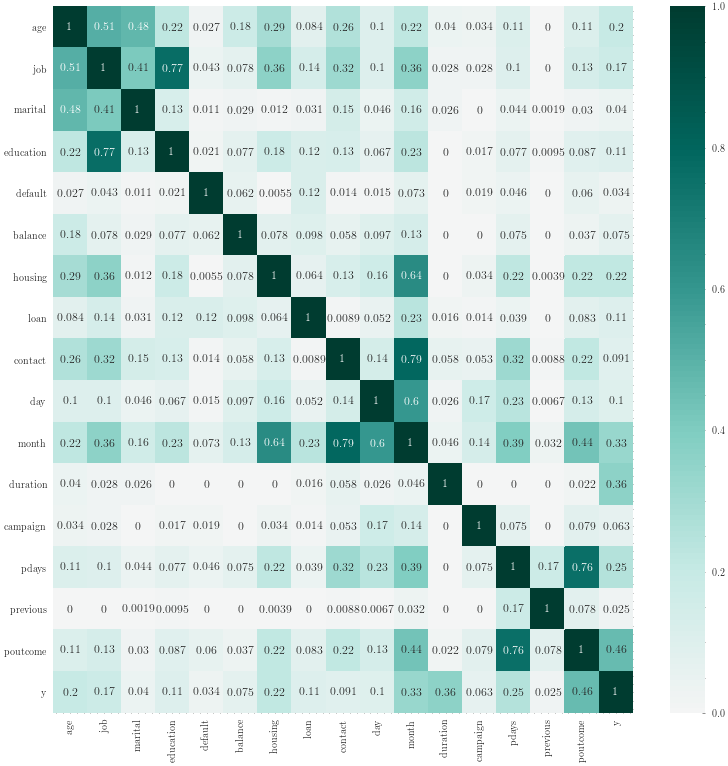

In [100]:
corr_matrix = bank_eda.phik_matrix(interval_cols = numerical_features)
fig, ax = plt.subplots(figsize=(13, 13))
# sns.heatmap(corr_matrix, annot = True, center = 0, cmap='BrBG')
sns.heatmap(corr_matrix, annot = True, center = 0, cmap='BrBG')
plt.savefig("corr.png", dpi=600)

## Data Preparation

In [101]:
y_encoder = LabelEncoder()
X, y = bank_df.drop('y', axis = 1), y_encoder.fit_transform(bank_df['y'])

### Dropping Features
We will drop duration from our dataset, as the duration of a call is unknown before a call is performed. Yet, at the end of the call, when the duration is known, the outcome is also known. Hence, the duration is not available during inference time, and hence is not useful.

In [102]:
X.drop("duration", axis=1, inplace=True)

### Baseline Data Preparation
We start with a baseline data preprocessing pipeline, which does not do anything with missing values, and performs basic scaling for numerical data.

In [103]:
numerical_features = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numerical_transformers = Pipeline([
    ('Robust Scaler', RobustScaler())
])

categorical_transformers = Pipeline([
    ('One Hot Encoder', OneHotEncoder(handle_unknown='ignore'))
])

data_preprocessing = ColumnTransformer([
    ('Preprocess Numerical Features', numerical_transformers, numerical_features),
    ('Preprocess Categorical Features', categorical_transformers, categorical_features)
])

## Data Split
We will split our data to obtain a hold-out test set to evaluate the performance of the final model. Cross Validation will be done on the rest of the data to evaluate various learning algorithms.

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y, test_size = .2)

In [105]:
X_train.shape

(36168, 15)

## Modelling

### Evaluation 
To standardize the evaluation of our candidate models, we will create a utility function which will do the following things:
1. Obtain a cross validated mean training and validation score of our model
2. Update a history of scores of past candidate models
3. Generate a learning curve of our model to help in evaluating bias and variance
4. If required, return the fitted model.

In [106]:
def evaluate_candidate_model(clf, X, y, metrics = ['balanced_accuracy','accuracy'], cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42), model_name = None, history = pd.DataFrame(), return_estimator = False, return_learning_curve = True):
    model_name = model_name if model_name is not None else type(clf).__name__
    single_metric = type(metrics) in { str, callable }
    scores = cross_validate(clf, X, y, cv = cv, scoring = metrics, return_train_score = True, return_estimator = return_estimator, n_jobs= -1)
    if return_estimator:
        best_estimator = scores["estimator"][np.argmax(scores["test_score"]) if single_metric else np.argmax(scores[f"test_{metrics[0]}"])]
        del scores["estimator"]
    scores = pd.DataFrame(scores).describe().iloc[1:3, 2:].round(5) # Get Summarized Cross Val Scores
    his_snapshot = scores.iloc[0, :]
    his_snapshot["Standard Error of Balanced Accuracy"] = scores["test_balanced_accuracy"].iloc[1] / np.sqrt(cv.get_n_splits())
    his_snapshot.rename(index=model_name, inplace=True)
    history = history.append(his_snapshot)
    if return_learning_curve:
      lr = learning_curve(clf, X, y, scoring = metrics if single_metric else metrics[0], cv = cv, n_jobs=-1)
    return scores, history, lr if return_learning_curve else None, best_estimator if return_estimator else None

### Baseline Model

In [107]:
baseline = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', DummyClassifier())
])

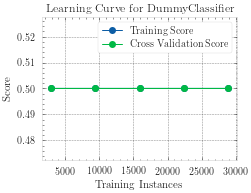

In [108]:
scores, history, lr, _ = evaluate_candidate_model(baseline, X_train, y_train, model_name= "Baseline Model")

Due to the imbalanced classes, the baseline model has a very high accuracy, however, we see that it has an balanced accuracy of only 0.5, as it is completely unable to predict the positive class.

### Logistic Regression

In [109]:
logreg = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', LogisticRegression(solver='liblinear'))
])

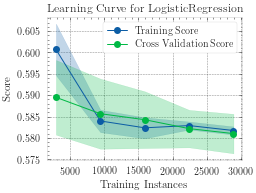

,test_balanced_accuracy,train_balanced_accuracy,test_accuracy,train_accuracy
mean,0.58090,0.58167,0.89209,0.89241
std,0.00512,0.00120,0.00051,0.00038


In [110]:
scores, history, lr, _ = evaluate_candidate_model(logreg,  X_train, y_train, history = history, model_name= "Logistic Regression")
display(scores)

In [111]:
history

,Standard Error of Balanced Accuracy,test_accuracy,test_balanced_accuracy,train_accuracy,train_balanced_accuracy
Baseline Model,0.00000,0.88302,0.5000,0.88302,0.50000
Logistic Regression,0.00229,0.89209,0.5809,0.89241,0.58167


A logistic regression model does better in terms of f1 score than the baseline, but the model still has a high bias due to the class imbalance.

### Evaluating Other Models
We use a for-loop to enumerate through various candidate models, to quickly see how without any other pre-processing, different models perform. 

In [112]:
models = [LinearSVC(random_state=random_state), RandomForestClassifier(random_state=random_state), DecisionTreeClassifier(random_state=random_state), GradientBoostingClassifier(random_state=random_state), HistGradientBoostingClassifier(random_state=random_state)]
for model in tqdm(models):
    model_name = type(model).__name__
    model = Pipeline([
        ('Data Preprocessing', data_preprocessing),
        ('Model', model)
    ])
    scores, history, lr, _ = evaluate_candidate_model(model, X_train, y_train, history= history, model_name=model_name, return_learning_curve = False)



100%|██████████| 5/5 [01:10<00:00, 14.07s/it]


### Native Handling of Categorical Variables

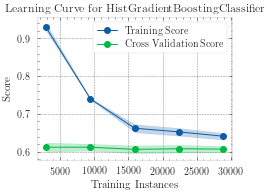

In [113]:
categorical_features_mask = [False] * len(numerical_features) + [True] * len(categorical_features)
clf = Pipeline([
    ("Data Preprocessing", ColumnTransformer([
                                                     ("Handle Numerical Features", numerical_transformers, numerical_features),
                                                     ("Handle Categorical Features", OrdinalEncoder(), categorical_features)])),
    ('Model', HistGradientBoostingClassifier(random_state=random_state, categorical_features=categorical_features_mask))
])
scores, history, lr, _ = evaluate_candidate_model(clf, X_train, y_train, history= history, model_name=f"{model_name} (Native Handling of Categorical Features)", return_learning_curve = True)

In [114]:
display(history)

,Standard Error of Balanced Accuracy,test_accuracy,test_balanced_accuracy,train_accuracy,train_balanced_accuracy
Baseline Model,0.000000,0.88302,0.50000,0.88302,0.50000
Logistic Regression,0.002290,0.89209,0.58090,0.89241,0.58167
LinearSVC,0.018604,0.84674,0.56569,0.84865,0.56865
RandomForestClassifier,0.003891,0.89184,0.60300,0.99995,0.99979
DecisionTreeClassifier,0.005984,0.82836,0.61565,1.00000,1.00000
GradientBoostingClassifier,0.002567,0.89424,0.59524,0.89861,0.60622
HistGradientBoostingClassifier,0.003927,0.89350,0.60528,0.90566,0.63633
HistGradientBoostingClassifier (Native Handling of Categorical Features),0.004190,0.89399,0.60709,0.90794,0.64318


Overall, we note that the model with the highest balanced accuracy is the Decision Tree Classifier.

## Solving the Class Imbalance Problem
One problem our learning algorithms face is the lack of enough positive classes in the training data. This limits our algorithms ability to predict the positive class. To solve this, we adopt a strategy of oversampling to generate more training examples of the positive class. 

### Random Oversampling

In [115]:
oversample_hist = history.copy()

In [116]:
models = [LogisticRegression(), RandomForestClassifier(random_state=random_state), DecisionTreeClassifier(random_state=random_state), HistGradientBoostingClassifier(random_state=random_state)]
for model in tqdm(models):
    model_name = type(model).__name__
    model = Pipeline([
        ('Data Preprocessing', data_preprocessing),
        ('Random Oversampling', RandomOverSampler(random_state=random_state)),
        ('Model', model)
    ])
    scores, oversample_hist, lr, _ = evaluate_candidate_model(model, X_train, y_train, history= oversample_hist, model_name=f"{model_name} (Random Oversampling)", return_learning_curve = False)

display(oversample_hist)

100%|██████████| 4/4 [00:55<00:00, 13.80s/it]


,Standard Error of Balanced Accuracy,test_accuracy,test_balanced_accuracy,train_accuracy,train_balanced_accuracy
Baseline Model,0.000000,0.88302,0.50000,0.88302,0.50000
Logistic Regression,0.002290,0.89209,0.58090,0.89241,0.58167
LinearSVC,0.018604,0.84674,0.56569,0.84865,0.56865
RandomForestClassifier,0.003891,0.89184,0.60300,0.99995,0.99979
DecisionTreeClassifier,0.005984,0.82836,0.61565,1.00000,1.00000
GradientBoostingClassifier,0.002567,0.89424,0.59524,0.89861,0.60622
HistGradientBoostingClassifier,0.003927,0.89350,0.60528,0.90566,0.63633
HistGradientBoostingClassifier (Native Handling of Categorical Features),0.004190,0.89399,0.60709,0.90794,0.64318
LogisticRegression (Random Oversampling),0.002750,0.73855,0.69490,0.74036,0.69941
RandomForestClassifier (Random Oversampling),0.005062,0.88526,0.63639,1.00000,1.00000


Performing Random Oversampling on the training fold helps improves the balanced accuracy and f1 score of the overall models. Using balanced accuracy, we find that Gradient Boosted Trees perform the best.

We also note that RandomForests is able to overtake the Decision Tree classifier after random oversampling is done on the model.

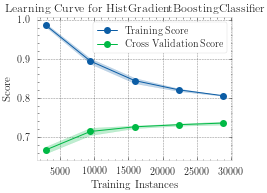

In [117]:
categorical_features_mask = [False] * len(numerical_features) + [True] * len(categorical_features)
clf = Pipeline([
    ("Data Preprocessing", ColumnTransformer([
                                                     ("Handle Numerical Features", numerical_transformers, numerical_features),
                                                     ("Handle Categorical Features", OrdinalEncoder(), categorical_features)])),
    ("Random Oversampling", RandomOverSampler(random_state=random_state)),
    ('Model', HistGradientBoostingClassifier(random_state=random_state, categorical_features=categorical_features_mask))
])
scores, oversample_hist, lr, _ = evaluate_candidate_model(clf, X_train, y_train, history= oversample_hist, model_name=f"{model_name} (Random Sampling & Native Handling of Categorical Features)", return_learning_curve = True)

### SMOTE-NC

In [118]:
numerical_features

['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

In [119]:
cat_features_colselect = [col in categorical_features for col in X_train.columns]
categorical_features_boolary = [True] * len(categorical_features) + [False] * len(numerical_features)
numerical_features_boolary =  [False] * len(numerical_features) + [True] * len(categorical_features)

In [120]:
smote_nc = Pipeline([
                     ("Encode Categorical as Numeric", ColumnTransformer(
                         [("Encode Cat as Numerical", OrdinalEncoder(), cat_features_colselect)]
                     , remainder="passthrough")),
                     ("SMOTE-NC", SMOTENC(categorical_features=categorical_features_boolary, random_state=random_state))
])

In [121]:
models = [LogisticRegression(), RandomForestClassifier(random_state=random_state), DecisionTreeClassifier(random_state=random_state), HistGradientBoostingClassifier(random_state=random_state)]
for model in tqdm(models):
    model_name = type(model).__name__
    model = Pipeline([
        ("Encode Categorical as Numeric", ColumnTransformer(
            [("Encode Cat as Numerical", OrdinalEncoder(), cat_features_colselect)]
        , remainder="passthrough")),
        ("SMOTE-NC", SMOTENC(categorical_features=categorical_features_boolary, random_state=random_state)),
        ("OHE", ColumnTransformer(
            [("OHE", OneHotEncoder(), categorical_features_boolary), ("RobustScaler", RobustScaler(), numerical_features_boolary)]
        )),
        ('Model', model)
    ])
    scores, oversample_hist, lr, _ = evaluate_candidate_model(model, X_train, y_train, history= oversample_hist, model_name=f"{model_name} (SMOTE-NC)", return_learning_curve = False)

display(oversample_hist)

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
100%|██████████| 4/4 [02:31<00:00, 37.81s/it]


,Standard Error of Balanced Accuracy,test_accuracy,test_balanced_accuracy,train_accuracy,train_balanced_accuracy
Baseline Model,0.000000,0.88302,0.50000,0.88302,0.50000
Logistic Regression,0.002290,0.89209,0.58090,0.89241,0.58167
LinearSVC,0.018604,0.84674,0.56569,0.84865,0.56865
RandomForestClassifier,0.003891,0.89184,0.60300,0.99995,0.99979
DecisionTreeClassifier,0.005984,0.82836,0.61565,1.00000,1.00000
GradientBoostingClassifier,0.002567,0.89424,0.59524,0.89861,0.60622
HistGradientBoostingClassifier,0.003927,0.89350,0.60528,0.90566,0.63633
HistGradientBoostingClassifier (Native Handling of Categorical Features),0.004190,0.89399,0.60709,0.90794,0.64318
LogisticRegression (Random Oversampling),0.002750,0.73855,0.69490,0.74036,0.69941
RandomForestClassifier (Random Oversampling),0.005062,0.88526,0.63639,1.00000,1.00000


## Further Model Improvement

In [122]:
clf = Pipeline([
        ("Encode Categorical as Numeric", ColumnTransformer(
            [("Encode Cat as Numerical", OrdinalEncoder(), cat_features_colselect)]
        , remainder="passthrough")),
        ("SMOTE-NC", SMOTENC(categorical_features=categorical_features_boolary, random_state=random_state)),
        ("RobustScaling", ColumnTransformer(
            [("RobustScaler", RobustScaler(), [9, 10, 11, 12, 13, 14])], remainder="passthrough"
        ))
    ])
pd.DataFrame(clf.fit_transform(X_train, y_train))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.181587,0.182942,1.151185,0.000000,0.000000,0.000000,9.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0
1,-0.907935,2.200865,-0.822275,1.000000,3.172867,7.000000,8.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.302645,-0.198393,-0.246683,1.000000,0.000000,0.000000,9.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0
3,0.544761,-0.349197,1.315640,4.500000,0.000000,0.000000,10.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0,3.0
4,-0.060529,-0.190358,0.904503,4.000000,0.000000,0.000000,9.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63869,0.471602,-0.467601,-0.333118,-0.210630,0.000000,0.000000,1.0,1.0,0.0,0.0,1.0,1.0,0.0,5.0,3.0
63870,-0.423703,1.219369,0.851335,1.806024,0.000000,0.000000,9.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0
63871,1.277527,-0.165799,0.060631,0.315661,0.000000,0.000000,4.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0,3.0
63872,0.936062,1.783680,-0.377720,-0.500000,3.104633,2.090313,9.0,2.0,2.0,0.0,0.0,0.0,0.0,3.0,2.0


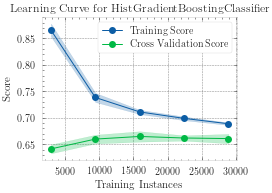

In [123]:
hist_mask = [False] * len(numerical_features) + [True] * len(categorical_features)
clf = Pipeline([
        ("Encode Categorical as Numeric", ColumnTransformer(
            [("Encode Cat as Numerical", OrdinalEncoder(), cat_features_colselect)]
        , remainder="passthrough")),
        ("SMOTE-NC", SMOTENC(categorical_features=categorical_features_boolary, random_state=random_state)),
        ("RobustScaling", ColumnTransformer(
            [("RobustScaler", RobustScaler(),  [9, 10, 11, 12, 13, 14])], remainder="passthrough"
        )),
        ('Model', HistGradientBoostingClassifier(categorical_features=hist_mask))
    ])
scores, oversample_hist, lr, _ = evaluate_candidate_model(clf, X_train, y_train, history= oversample_hist, model_name=f"{model_name} (SMOTE-NC & Native Handling of Categorical Features)", return_learning_curve = True)

In [133]:
oversample_hist[["train_balanced_accuracy", "train_accuracy", "test_balanced_accuracy", "test_accuracy"]]

,train_balanced_accuracy,train_accuracy,test_balanced_accuracy,test_accuracy
Baseline Model,0.50000,0.88302,0.50000,0.88302
Logistic Regression,0.58167,0.89241,0.58090,0.89209
LinearSVC,0.56865,0.84865,0.56569,0.84674
RandomForestClassifier,0.99979,0.99995,0.60300,0.89184
DecisionTreeClassifier,1.00000,1.00000,0.61565,0.82836
GradientBoostingClassifier,0.60622,0.89861,0.59524,0.89424
HistGradientBoostingClassifier,0.63633,0.90566,0.60528,0.89350
HistGradientBoostingClassifier (Native Handling of Categorical Features),0.64318,0.90794,0.60709,0.89399
LogisticRegression (Random Oversampling),0.69941,0.74036,0.69490,0.73855
RandomForestClassifier (Random Oversampling),1.00000,1.00000,0.63639,0.88526


In [124]:
oversample_hist.dropna().sort_values("test_balanced_accuracy")

,Standard Error of Balanced Accuracy,test_accuracy,test_balanced_accuracy,train_accuracy,train_balanced_accuracy
Baseline Model,0.000000,0.88302,0.50000,0.88302,0.50000
LinearSVC,0.018604,0.84674,0.56569,0.84865,0.56865
Logistic Regression,0.002290,0.89209,0.58090,0.89241,0.58167
GradientBoostingClassifier,0.002567,0.89424,0.59524,0.89861,0.60622
RandomForestClassifier,0.003891,0.89184,0.60300,0.99995,0.99979
HistGradientBoostingClassifier,0.003927,0.89350,0.60528,0.90566,0.63633
DecisionTreeClassifier (Random Oversampling),0.003238,0.83532,0.60668,1.00000,1.00000
HistGradientBoostingClassifier (Native Handling of Categorical Features),0.004190,0.89399,0.60709,0.90794,0.64318
DecisionTreeClassifier,0.005984,0.82836,0.61565,1.00000,1.00000
DecisionTreeClassifier (SMOTE-NC),0.003095,0.80806,0.62261,1.00000,1.00000


### Hyperparameter Tuning

In [127]:
from yellowbrick.model_selection import validation_curve

In [128]:
param_randomoversample = {
    "Random Oversampling__sampling_strategy" : [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
categorical_features_mask = [False] * len(numerical_features) + [True] * len(categorical_features)
clf = Pipeline([
    ("Data Preprocessing", ColumnTransformer([
                                                     ("Handle Numerical Features", numerical_transformers, numerical_features),
                                                     ("Handle Categorical Features", OrdinalEncoder(), categorical_features)])),
    ("Random Oversampling", RandomOverSampler(random_state=random_state)),
    ('Model', HistGradientBoostingClassifier(random_state=random_state, categorical_features=categorical_features_mask))
])


In [131]:
plt.style.use("classic")

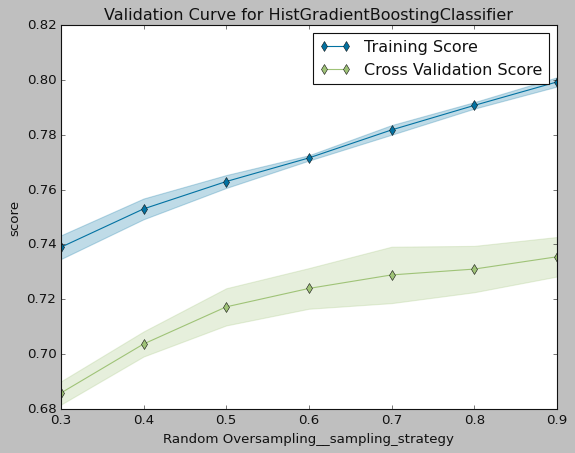

ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f3661472550>,
                estimator=Pipeline(steps=[('Data Preprocessing',
                                           ColumnTransformer(transformers=[('Handle '
                                                                            'Numerical '
                                                                            'Features',
                                                                            Pipeline(steps=[('Robust '
                                                                                             'Scaler',
                                                                                             RobustScaler())]),
                                                                            ['age',
                                                                             'balance',
                                                                             'day',
             

In [132]:
validation_curve(clf, X_train, y_train, "Random Oversampling__sampling_strategy", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], scoring="balanced_accuracy")

## Model Evaluation

In [135]:
categorical_features_mask = [False] * len(numerical_features) + [True] * len(categorical_features)
clf = Pipeline([
    ("Data Preprocessing", ColumnTransformer([
                                                     ("Handle Numerical Features", numerical_transformers, numerical_features),
                                                     ("Handle Categorical Features", OrdinalEncoder(), categorical_features)])),
    ("Random Oversampling", RandomOverSampler(random_state=random_state)),
    ('Model', HistGradientBoostingClassifier(random_state=random_state, categorical_features=categorical_features_mask))
])
clf.fit(X_train , y_train)

Pipeline(steps=[('Data Preprocessing',
                 ColumnTransformer(transformers=[('Handle Numerical Features',
                                                  Pipeline(steps=[('Robust '
                                                                   'Scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'balance', 'day',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('Handle Categorical Features',
                                                  OrdinalEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'mon

In [136]:
from sklearn.metrics import balanced_accuracy_score

In [137]:
y_pred = clf.predict(X_test)

In [138]:
balanced_accuracy_score(y_test, y_pred)

0.7380655837445683

In [139]:
confusion_matrix(y_test, y_pred)

array([[6851, 1134],
       [ 404,  654]])